El objetivo de este código es hacer una partición de los datos por sujeto. Se reserva un sujeto para test, otro para validación, y el resto para entrenar. Luego se implementa un mlp.



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


Importo las librerías y los datos

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

sys.path.append('/content/drive/My Drive/repo_tesis/lib')
import classes as cl

features = load("/content/drive/My Drive/repo_tesis/data/FEATURES_W200_I50.joblib")
label = load("/content/drive/My Drive/repo_tesis/data/label_W200_I50.joblib")

Construyo cada conjunto de datos haciendo la división por sujeto.


*   Dos sujetos para test.
*   Dos sujetos para validación.
*   El resto para entrenamiento.

Esto lo dejé así por defecto pero puede modificarse fácilmente.





In [39]:
# Calculo la cantidad de sujetos
label = np.array(label)
cantSujetos = np.max(label[:, 2])

# Hago un sorteo a ver que sujeto va para cada conjunto
sorteo = np.random.permutation(cantSujetos) + 1

# El primer sujeto del sorteo va a test, el segundo a val y el resto a train
indices_test = list(np.where(label[:, 2]==sorteo[0])[0])
indices_val = list(np.where(label[:, 2]==sorteo[2])[0])

indices_test.extend(list(np.where(label[:, 2]==sorteo[1])[0]))
indices_val.extend(list(np.where(label[:, 2]==sorteo[3])[0]))

indices_train = []
for j in sorteo[4:]:
    indices_train.extend(np.where(label[:, 2]==j)[0])

# lo paso a numpy array para poder definir de forma mas comoda los conjuntos de train test y val
features = np.array(features)

X_train = features[indices_train, :]
y_train = label[indices_train, 1]
X_val = features[indices_val, :]
y_val = label[indices_val, 1]
X_test =  features[indices_test, :]
y_test = label[indices_test, 1]

Entreno una red neuronal de arquitectura 250-500-250.

In [40]:
import time
# Quiero calcular el tiempo que demora en entrenarse el algoritmo
start_time = time.time()

# Parametros de entrada de la red neuronal que tenemos que definir
# Definimos a mano la cantidad de features
featureNum = 15
chNum = 16
# Numero de columnas que va a haber en features
inputDim = chNum*featureNum
# Numero de gestos contando el reposo
clasNum = np.max(label[:, 1]) + 1

# Architecture 250 - 500 - 250
red = cl.Clasificador(model= "mlp", arch = [250,500,250], catNum = clasNum, featureNum = inputDim)
red.train(X_train, y_train, X_val, y_val)

end_time = time.time()
training_time = end_time - start_time

# Calculo las etiquetas predecidas por el modelo
y_pred = red.predict(X_test)

Epoch 1/50
2448/2448 [==============================] - 15s 6ms/step - loss: 1.5928 - accuracy: 0.4387 - val_loss: 2.3371 - val_accuracy: 0.2810
Epoch 2/50
2448/2448 [==============================] - 15s 6ms/step - loss: 1.2365 - accuracy: 0.5672 - val_loss: 2.6595 - val_accuracy: 0.2755
Epoch 3/50
2448/2448 [==============================] - 13s 5ms/step - loss: 1.0653 - accuracy: 0.6277 - val_loss: 3.1589 - val_accuracy: 0.2535
Epoch 4/50
2448/2448 [==============================] - 14s 6ms/step - loss: 0.9511 - accuracy: 0.6665 - val_loss: 3.0823 - val_accuracy: 0.2620
Epoch 5/50
2448/2448 [==============================] - 13s 5ms/step - loss: 0.8664 - accuracy: 0.6945 - val_loss: 3.3706 - val_accuracy: 0.2706
Epoch 6/50
2448/2448 [==============================] - 14s 6ms/step - loss: 0.7999 - accuracy: 0.7193 - val_loss: 3.6674 - val_accuracy: 0.2570
Epoch 7/50
2448/2448 [==============================] - 16s 7ms/step - loss: 0.7415 - accuracy: 0.7391 - val_loss: 3.7730 - val_ac

Voy a guardar el clasificador, y evaluar distintas métricas: accuracy, precision y recall. Voy a hacer una matriz de confusión.
Por otra parte, voy a guardar la partición de los datos para hacer reproducible el experimento.

416/416 [==============================] - 1s 2ms/step
Accuracy: 0.2697576396206533
Precision: 0.26881591163758084
Recall: 0.2697576396206533


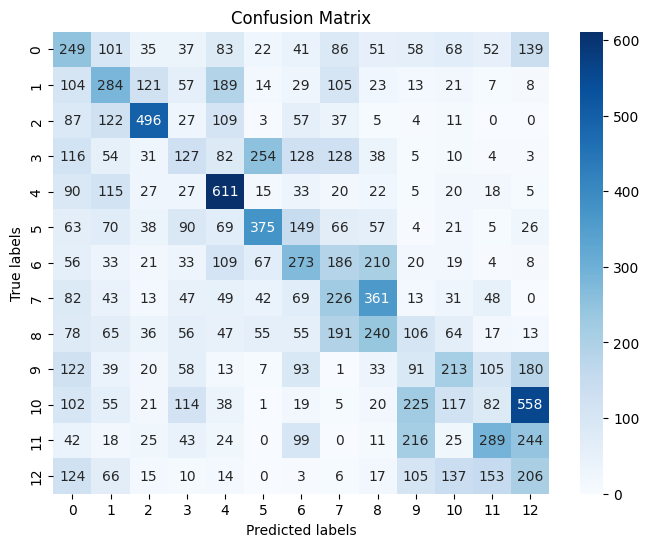

<Figure size 640x480 with 0 Axes>

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import joblib
import seaborn as sns

# Guardar el modelo entrenado en un archivo
joblib.dump(red, 'baseline_mlp_sep_sub_r1.pkl')

# Predecir en el conjunto de test
y_pred = red.predict(X_test)

# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Guardar la imagen de la matriz de confusión
plt.savefig("confusion_matrix.png")

Voy a guardar las métricas calculadas en un experimento en Comet


In [42]:
#!pip install comet_ml

In [43]:
from comet_ml import Experiment
# Conectar con Comet
API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO' # Se puede encontrar en Settings(Arriba a la derecha en Comet)

# Crear un experimento con mi API KEY
exp = Experiment(api_key=API_KEY,
                 project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False)
exp.set_name('baseline_mlp_sep_sub_r1') # Nombre de este experimento
exp.add_tags(['baseline', 'mlp', 'sep_sub']) # Tags

exp.log_metric("accuracy", accuracy)
exp.log_metric("precision", precision)
exp.log_metric("recall", recall)
exp.log_metric("training_time", training_time)
exp.log_confusion_matrix(y_test, y_pred)
exp.log_parameter("partition_array", sorteo)   # Guarda el arreglo en el experimento
exp.log_text("Primeros dos sujetos --> test, tercero y cuarto --> validación, resto --> train. \n Corresponde a la primera ronda que entreno con estos parámetros. ")   # Comentario del experimento

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, tensorboard, sklearn, keras, lightgbm.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/38a829ae4f3c4342ab0a01b1b44da3e1



{'web': 'https://www.comet.com/api/asset/download?assetId=d42da817e0d049b4b68fb62dd4db0c23&experimentKey=38a829ae4f3c4342ab0a01b1b44da3e1',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=d42da817e0d049b4b68fb62dd4db0c23&experimentKey=38a829ae4f3c4342ab0a01b1b44da3e1',
 'assetId': 'd42da817e0d049b4b68fb62dd4db0c23'}

In [44]:
# Subir el modelo
exp.log_model(name="baseline_mlp_sep_sub_r1", file_or_folder="baseline_mlp_sep_sub_r1.pkl")
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/38a829ae4f3c4342ab0a01b1b44da3e1
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.2697576396206533
COMET INFO:     precision     : 0.26881591163758084
COMET INFO:     recall        : 0.2697576396206533
COMET INFO:     training_time : 743.0745401382446
COMET INFO:   Others:
COMET INFO:     Name : baseline_mlp_sep_sub_r1
COMET INFO:   Parameters:
COMET INFO:     partition_array : [ 5  7  3  9 10  4  8  6  1  2]
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git m